---
# <center> Master M2 MVA - Computational Statistics
    
# <center>  TP 4: Improve the Metropolis-Hastings Algorithm
    
<center> Realized By: Eya Ghamgui
<center> eya.ghamgui@telecom-paris.fr
    
    
--- 

## Import Libraires 

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import warnings
warnings.filterwarnings("ignore")

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

### 1.A – Metropolis-Hastings within Gibbs sampler

We aim to sample the target distribution $\pi$, on $\mathbb{R}$, given by
$$(x,y) \mapsto  \pi(x,y) \propto exp( - \frac{x^2}{a^2} - y^2 -\frac{1}{4}(\frac{x^2}{a^2} - y^2)^2)  $$ 

where $a > 0$. We consider a Markov transition kernel $P$ defined by
$$P = \frac{1}{2}(P_1 + P_2) $$

where $P_i((x, y) ; dx' \times dy')$ for $i = 1, 2$ is the Markov transition kernel which only updates the i-th component: this update follows a symmetric random walk proposal mechanism and uses a Gaussian distribution with variance $ \sigma_i^2$.

#### <font color = 'red'> Question 1: 

Implement an algorithm which samples the distribution $P_1(z; ·)$ where $z \in \mathbb{R}^2$; likewise for the
distribution $P_2(z; ·)$. Then, implement an algorithm which samples a chain with kernel $P$.

In [2]:
# Target distribution 
def log_pi(x,y,a):
    return(-(x/a)**2-y**2-(1/4)*(((x/a)**2-y**2)**2))


# Sample the distribution P1
def sample_P1(x0,y0,sigma,a) : 
    
    x_ = np.random.normal(x0, sigma[0],size=1)[0]
    log_a = log_pi(x_ ,y0 , a) - log_pi(x0,y0,a)
    log_a = np.min([0, log_a])
    log_u = np.log(np.random.rand())
    
    if log_u <= log_a :
        return x_,y0,np.exp(log_a),True
    else: 
        return x0,y0,np.exp(log_a),False
    
    
# Sample the distribution P2
def sample_P2(x0,y0,sigma,a) : 
    
    y_ = np.random.normal(y0,sigma[1],size=1)[0]
    log_a = log_pi(x0,y_ , a) - log_pi(x0,y0,a)
    log_a = np.min([0, log_a])
    log_u = np.log(np.random.rand())
    
    if log_u <= log_a :
        return x0,y_,np.exp(log_a),True 
    else: 
        return x0,y0,np.exp(log_a),False
    
    
# Sample a chain with kernel P
def sample_P(x0,y0,p,sigma,a,N):
    
    # Initiate the variables 
    sam = np.zeros((N,2))
    sam[0,:] = [x0,y0]
    acc_rate_x = 0
    acc_rate_y = 0 
    acc_x=[]
    acc_y=[]
    
    for i in range(1,N):
        
        u = np.random.uniform()
        if u<=p :
            x , y , val, b  = sample_P1(sam[i-1,0],sam[i-1,1],sigma,a) 
            sam[i,:] = [x,y]
            if b : 
                acc_rate_x +=1 
        
        else:
            x , y , val, b = sample_P2(sam[i-1,0],sam[i-1,1],sigma,a) 
            sam[i,:] = [x,y]
            if b : 
                acc_rate_y +=1 
            
        # For each batch 
        if (i % 50 == 0) : 
            acc_x.append(acc_rate_x/50)
            acc_y.append(acc_rate_y/50)
            acc_rate_x = 0 
            acc_rate_y = 0 
                
    return(sam , acc_x , acc_y)

#### <font color = 'red'> Question 2: 

Run the algorithm with $a = 10$ and standard deviations of the proposal distributions chosen as follows: $(\sigma_1, \sigma_2) = (3, 3)$. Discuss the performance of the algorithm in this situation.

**1. Sampling Results** 

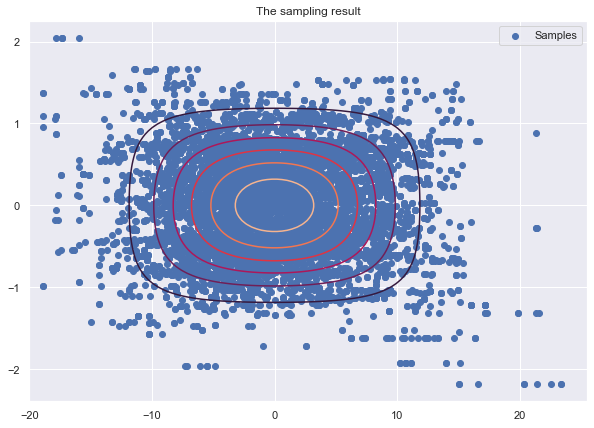

In [3]:
# Testing the algorithm 
sam , acc_x , acc_y = sample_P(1,1,0.5,[3,3],10,10000) 

# Computing the target distribution 
x = np.linspace(-20,20 ,100)
y = np.linspace(-2,2,100)
X, Y = np.meshgrid(x, y) 
Z = np.exp(log_pi(X, Y, 10)).reshape(X.shape)

# Plots
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.scatter(sam[:,0],sam[:,1] , label = 'Samples')
plt.title('The sampling result')
plt.legend()
plt.show()

**2. Acceptance Rate**

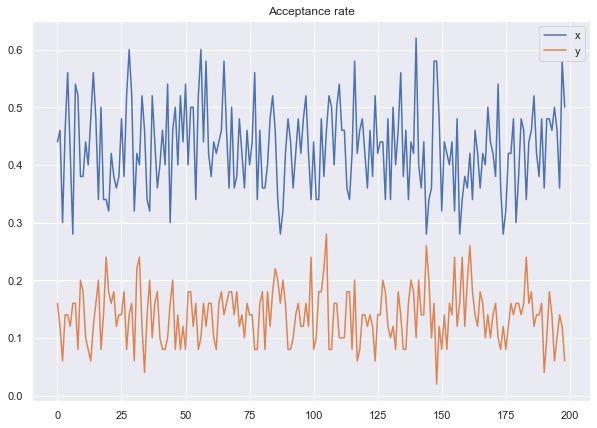

In [4]:
plt.figure(figsize=(10,7))
plt.plot(acc_x , label = 'x')
plt.plot(acc_y , label = 'y')
plt.legend()
plt.title('Acceptance rate')
plt.show()

**3. Autocorrelation Plots** 

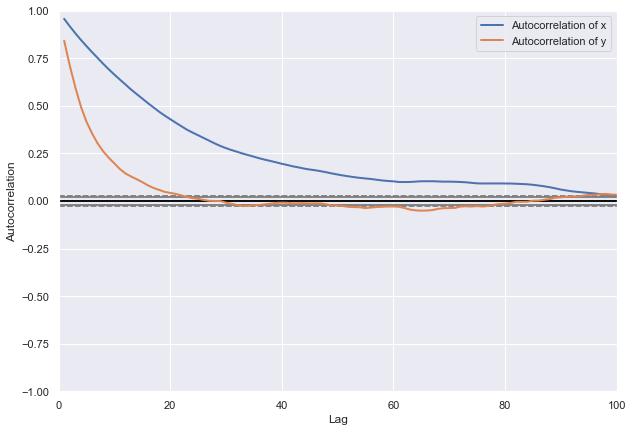

In [5]:
# Creating Autocorrelation plots
plt.figure(figsize=(10,7))
pd.plotting.autocorrelation_plot(sam[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(sam[:,1], label = 'Autocorrelation of y',linewidth=2)

# Limits the lags in the plot
plt.xlim((0,100))
plt.show()

**4. Interpretation** 

> From the previous sampling results, we can notice that the sampling is poor with this method. Indeed, there are many points sampled outside the distribution, especially along the x-axis. The acceptance rates are far from the best value $0.24$. Furthermore, the autocorrelation plot of the x-coordinate shows non-convergence, meaning that the points sampled along the x-axis are still correlated and do not exhibit randomness. In other words, the variance on the x-axis is probably small. On the other hand, the autocorrelation plot of the y-coordinate starts to converge. 

#### <font color = 'red'> Question 3: 

How could the performance of the above algorithm be improved ? Propose two methods.


> As we have seen before, the sampling performance in the x-coordinate is poor. To improve this performance, I propose two improvements. The first one is to increase the sampling probability in the x-coordinate. The second one is to change the variance of the axis from equal variance to unequal variance with a higher value in the x-coordinate and a lower value in the y-coordinate to force variability in the x-coordinate. 

**Method 1: Increase the probability of sampling the x-coordinate from 0.5 to 0.8 as an example.**

**1. Sampling Results** 

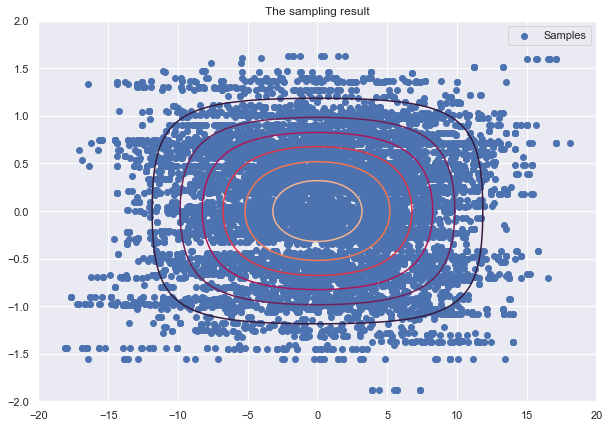

In [6]:
# Change probability from 0.5 to 0.8
sam , acc_x , acc_y = sample_P(1,1,0.8,[3,3],10,10000) 

# Plots
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.scatter(sam[:,0],sam[:,1] , label = 'Samples')
plt.title('The sampling result')
plt.legend()
plt.show()

**2. Acceptance Rate**

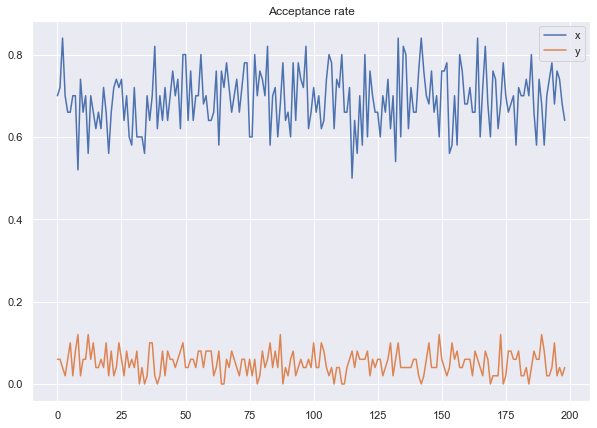

In [7]:
plt.figure(figsize=(10,7))
plt.plot(acc_x , label = 'x')
plt.plot(acc_y , label = 'y')
plt.legend()
plt.title('Acceptance rate')
plt.show()

**3. Autocorrelation Plots** 

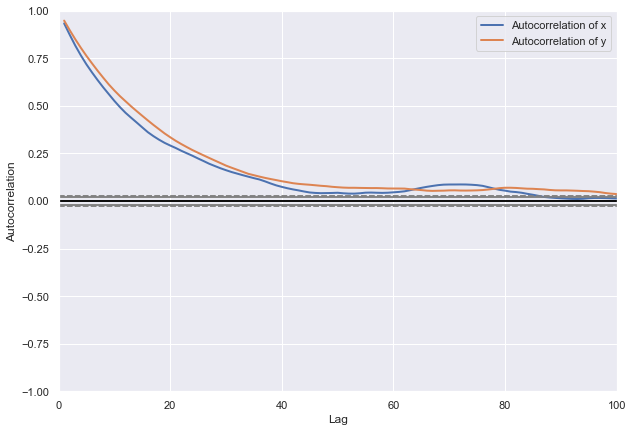

In [8]:
# Creating Autocorrelation plots
plt.figure(figsize=(10,7))
pd.plotting.autocorrelation_plot(sam[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(sam[:,1], label = 'Autocorrelation of y',linewidth=2)

# Limits the lags in the plot
plt.xlim((0,100))
plt.show()

**4. Interpretation**

> Here, the sampling is closer to the density distribution. In addition, the autocorrelation plots of the x-coordinate and y-coordinate are close. However, the acceptance rate of the x-coordinate becomes higher. But, we can say that this method has improved the previous results.

**Method 2: Changing the values of $\sigma_i$.**

**1. Sampling Results** 

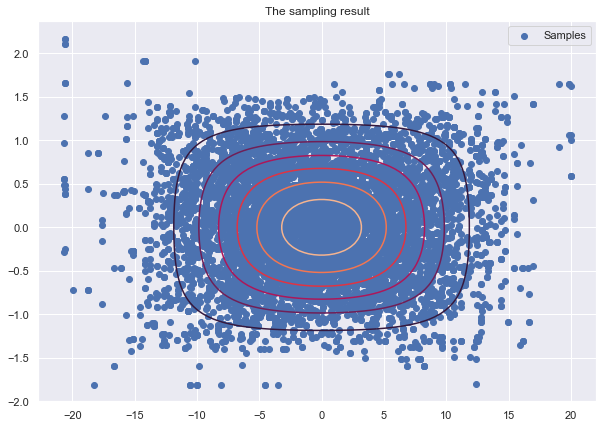

In [9]:
# sigma1 = 6
# sigma2 = 1
sam , acc_x , acc_y = sample_P(1,1,0.5,[6,1],10,10000) 

# Plots
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.scatter(sam[:,0],sam[:,1] , label = 'Samples')
plt.title('The sampling result')
plt.legend()
plt.show()

**2. Acceptance Rate**

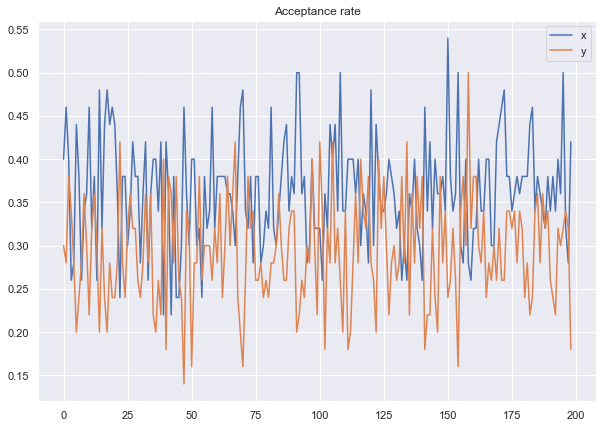

In [10]:
plt.figure(figsize=(10,7))
plt.plot(acc_x , label = 'x')
plt.plot(acc_y , label = 'y')
plt.legend()
plt.title('Acceptance rate')
plt.show()

**3. Autocorrelation Plots** 

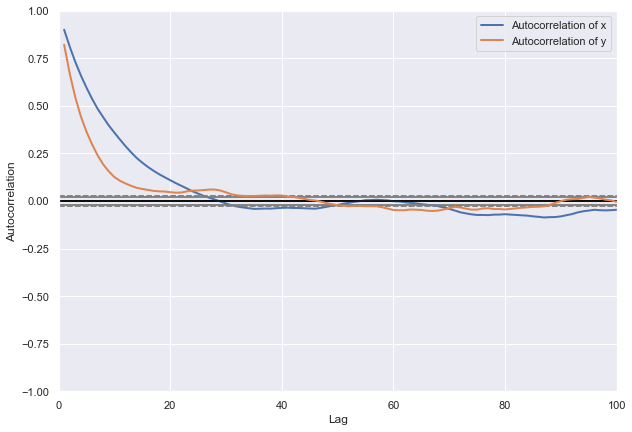

In [11]:
# Creating Autocorrelation plots
plt.figure(figsize=(10,7))
pd.plotting.autocorrelation_plot(sam[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(sam[:,1], label = 'Autocorrelation of y',linewidth=2)

# Limits the lags in the plot
plt.xlim((0,100))
plt.show()

**4. Interpretation** 

> We can notice that the sampling is much closer to the density distribution and that the acceptance rate of the x-coordinate becomes close to that of the y-coordinate which is almost around $0.24$. The autocorrelation curves are close and converge quickly. That is, this method has the best results. 

### 1.B – Adaptive Metropolis-Hastings within Gibbs sampler

We proceed as follows: 

- For each of the variables $x_i$, we create an associate variable $l_i$ giving for the logarithm of the standard deviation $\sigma_i$ to be used when proposing a normal increment to variable: $l_i = \log(\sigma_i)$;
<br><br>
- We initialize all $l_i$ to zero, which correspond to the unit proposal variance;
<br><br>
- After the j-th ($j \in \mathbb{N}^*$) batch of $50$ iterations, each variable $l_i$ is updated by adding or subtracting an amount $\delta (j)$. The adapting attempts to make the acceptance rate of proposals for variable $x_i$ as close as possible to $0.24$, which is optimal for one-dimensional proposals in certain settings. Specifically, if the acceptance rate for the i-th variable is greater than $0.24$, $l_i$ is increased with $\delta (j)$. Otherwise, if the rate is lower than $0.24$, $l_i$ is decreased by $\delta (j)$. In practice, we (can) take $\delta (j) := min(0.01, j^{−1/2})$.

#### <font color = 'red'> Question 1: 

Implement the adaptative Metropolis-Hastings within Gibbs sampler and test the algorithm on the density $\pi$ defined in the part A: Using auto-correlation plots (use a built-in function), compare the performance of the algorithm with or without adaptation.

In [12]:
def Ada_MH(x0,y0,p,a,N):
    
    # Initiate the variables 
    ## Old variables 
    sam = np.zeros((N,2))
    sam[0,:] = [x0,y0]
    acc_rate_x = 0
    acc_rate_y = 0
    acc_x=[]
    acc_y=[]
    ## New variables 
    l1 = 0
    l2 = 0
    j = 0
    
    for i in range(1,N):
        
        u=np.random.uniform()
        if u<=p :
            x , y , val, b = sample_P1(sam[i-1,0],sam[i-1,1],[np.exp(l1),np.exp(l2)],a) 
            sam[i,:] = [x,y]
            if b : 
                acc_rate_x+=1
            
        else:
            x , y , val, b = sample_P2(sam[i-1,0],sam[i-1,1],[np.exp(l1),np.exp(l2)],a) 
            sam[i,:] = [x,y]
            if b :
                acc_rate_y+=1           
            
        if (i % 50 == 0) : 
            
            ####################
            # The adaptive part 
            ####################
            j+=1
            if acc_rate_x/50 > 0.24 :
                l1 += min(0.01,1/np.sqrt(j))      
            else: 
                l1 -= min(0.01,1/np.sqrt(j))
                
            if acc_rate_y/50 > 0.24 :
                l2 += min(0.01,1/np.sqrt(j))      
            else: 
                l2 -= min(0.01,1/np.sqrt(j))
                
            acc_x.append(acc_rate_x/50)
            acc_y.append(acc_rate_y/50)
            acc_rate_x = 0 
            acc_rate_y = 0 
            
    return sam , acc_x , acc_y

**1. Sampling Results** 

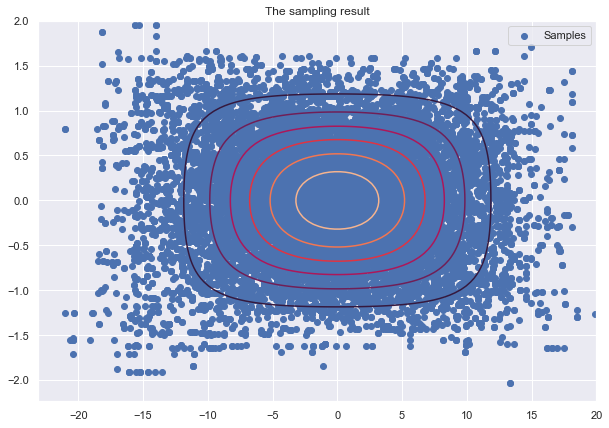

In [13]:
# Test the algorithm 
sam , acc_x , acc_y = Ada_MH(0,0,0.5,10,20000) 

# Plots
plt.figure(figsize=(10,7))
plt.contour(X, Y, Z)
plt.scatter(sam[:,0],sam[:,1] , label = 'Samples')
plt.title('The sampling result')
plt.legend()
plt.show()

**2. Acceptance Rate**

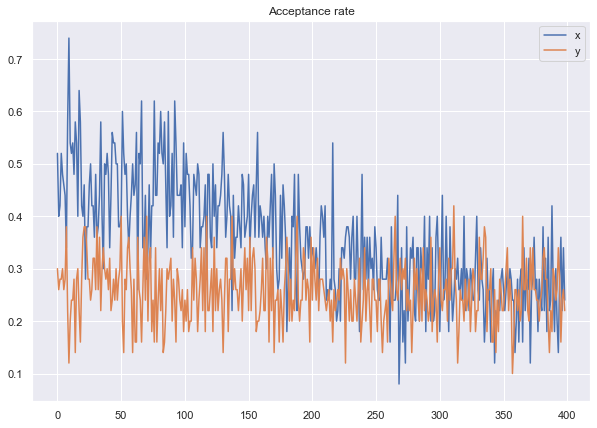

In [14]:
plt.figure(figsize=(10,7))
plt.plot(acc_x , label = 'x')
plt.plot(acc_y , label = 'y')
plt.legend()
plt.title('Acceptance rate')
plt.show()

**3. Autocorrelation plots restricted to samples with an acceptance rate arround $0.24$ for x and y coordinates** 

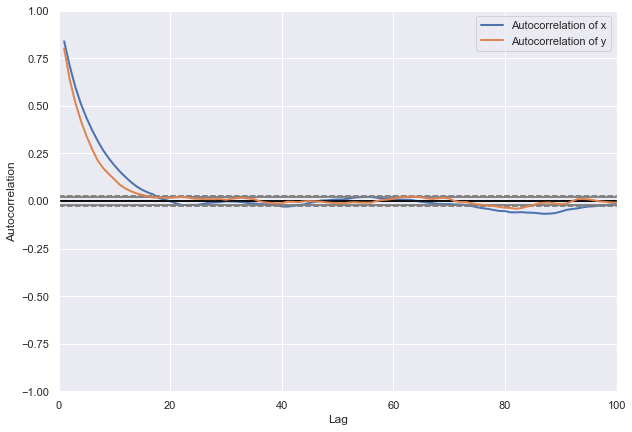

In [15]:
# Creating Autocorrelation plots
plt.figure(figsize=(10,7))
pd.plotting.autocorrelation_plot(sam[10000:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(sam[10000:,1], label = 'Autocorrelation of y',linewidth=2)

# Limits the lags in the plot
plt.xlim((0,100))
plt.show()

**4. Interpretaion**

> This is an adaptive method that starts from the original acceptance rates and tries to force their values towards $ 0.24$. To compare the two methods, we restrict the calculation of the autocorrelation to the set of samples whose acceptance rate is close to $ 0.24$ for the x and y coordinates.
<br> <br>
> We can notice that this method has improved the sampling and that the autocorrelation curves are very close and converge quickly, which means that the sampling is random. This method is considered better than the method without adaptation. It allows the acceptance rate to be corrected iteratively without having a prior on the variances and gives better sampling results.

#### <font color = 'red'> Question 2: 

We can also compare the performance of our algorithm on more complicated target densities. For example centered d-dimensional Gaussian $N (0, \Sigma)$ or "banana"-shaped density as in TP 2:

$$ \forall x = (x_1, ... , x_d) \in \mathbb{R}^d  f_B(x) \propto exp( - \frac{x_1^2}{200} -\frac{1}{2} (x_2 + B x_1^2 - 100 B)^2 -\frac{1}{2}(x_3^2 + ... + x_d^2) )  $$

In practice, you can choose $d = 20$ and $B = 0.1$ for the density $f_B$. You may also choose $d = 20$ for the second one and use the $20 \times 20$ variance-covariance matrix $\Sigma$ given in the file: http://dept.stat.lsa.umich.edu/~yvesa/tmalaexcov.txt.

**1. Build the data** 

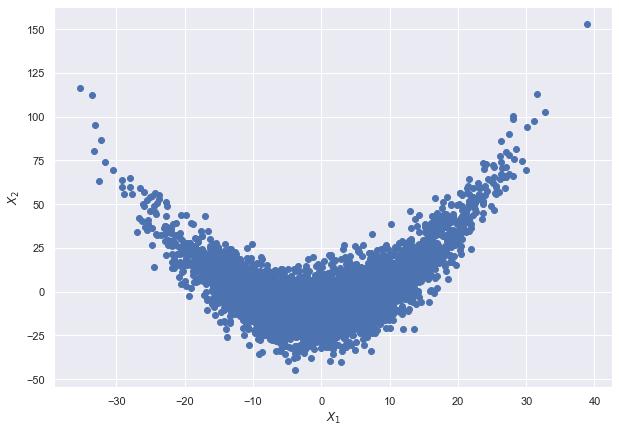

In [16]:
# Parameters 
d=20
B=0.1
sigma = np.array(pd.read_csv('tmalaexcov.txt' ,header=None , sep=' '))

# Create the data
data = np.random.multivariate_normal(mean=np.zeros(d),cov=sigma**2,size=5000)
data[:,1] = data[:,1] + B*(data[:,0]**2 - sigma[0,0]**2)

# Plots 
plt.figure(figsize=(10,7))
plt.scatter(data[:,0],data[:,1])
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

**2. Adaptive Metropolis-Hastings**

In [17]:
# Target distribution 
def log_fB(x,B):
    return(-(x[0]**2)/200.-(0.5)*(x[1]+B*x[0]**2-100*B)**2-(0.5)*(np.sum(x[2:]**2)))


def Ada_MH_Banana(x0,N,d,B,batch):

    # Initiate the variables
    sam = np.zeros((N,d))
    sam[0,:] = x0
    acc_x = np.zeros(d)
    l = np.zeros(d)
    j = 0
    
    for i in range(1,N):
        
        ind = np.random.randint(d)        
        x_ = copy.deepcopy(sam[i-1,:])
        x_[ind] = np.random.normal(sam[i-1,ind],np.exp(l[ind]))
        
        log_a = log_fB(x_,B)-log_fB(sam[i-1,:],B)
        log_a = np.min([0, log_a])
        log_u = np.log(np.random.rand())
        
        if log_u <= log_a :
            sam[i,:] = x_
            acc_x[ind] += 1
        else: 
            sam[i,:] = sam[i-1,:] 
           
        
        if (i % batch == 0) : 
            
            ####################
            # The adaptive part 
            ####################
            j+=1
            for k in range(d) : 
                if acc_x[k]/batch > 0.24 :
                    l[k] += min(0.01,1/np.sqrt(j))      
                else: 
                    l[k] -= min(0.01,1/np.sqrt(j))
            acc_x = np.zeros(d)
                    
    return sam 

**3. Sampling Results** 

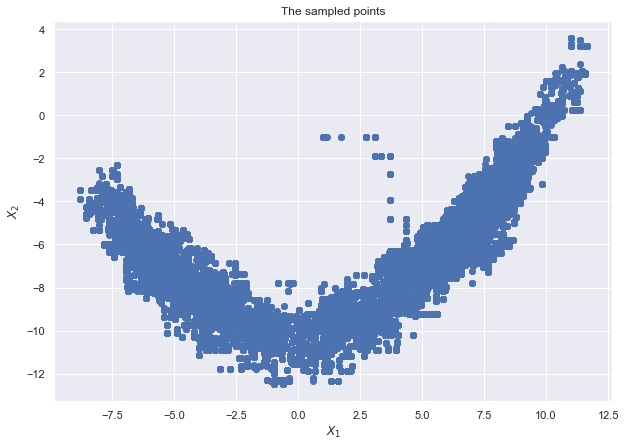

In [18]:
# Test the algorithm 
sam = Ada_MH_Banana(np.ones(d),100000,d,B,400)

# Plots 
plt.figure(figsize=(10,7))
plt.scatter(sam[:,0],-1*sam[:,1])
plt.title('The sampled points')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

**4. Autocorrelation Plots** 

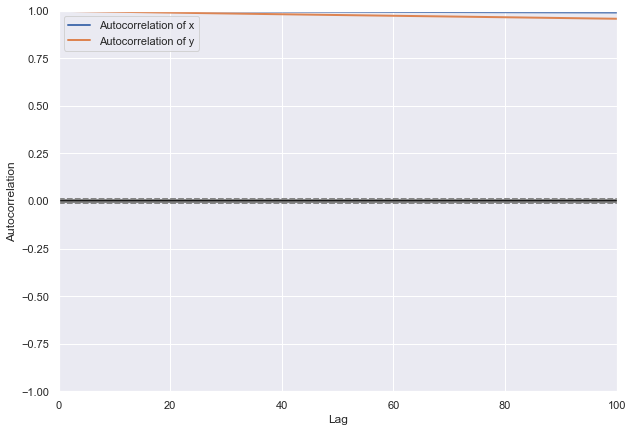

In [19]:
# Creating Autocorrelation plots
plt.figure(figsize=(10,7))
pd.plotting.autocorrelation_plot(sam[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(sam[:,1], label = 'Autocorrelation of y',linewidth=2)

# Limits the lags in the plot
plt.xlim((0,100))
plt.show()

**5. Interpretaion**

> We can notice that we are able to sample from the banana-shaped distribution. However, the autocorrelation curves are too high, which means that the data is not random. But, we can say that even though the target distribution is much more complicated, this adaptive algorithm is able to sample it and gives good performance. 

## Exercise 2: Sampling from multimodal distributions

### 2.A – A toy example

#### <font color = 'red'> Question 1: 

Write a Metropolis-Hastings Symmetric Random Walk algorithm (you may use your code from previous tutorial classes) to sample from $\pi$.

**1. Metropolis-Hastings Symmetric Random Walk algorithm**

In [20]:
# Target distribution 
def pi (x,mu,sigma,w,N):
    
    pi_ = 0
    for i in range(N):
        pi_ += w[i]/(2*np.pi*sigma[i]**2) * np.exp(-(x-mu[i,:]).T.dot(x-mu[i,:])/(2*sigma[i]**2))
    return pi_
    
    
def sample(x, mu, sigma, w, n, d, N):

    sam = np.zeros((N,d))
    sam[0,:] = x
    
    for i in range(1,N):
        
        ####################
        # Sample from x axis
        ####################
        x_ = np.random.normal(sam[i-1,0],1)
        X = np.array([x_ , sam[i-1,1]])
        
        alpha = min(1 , pi(X,mu,sigma,w,n) / pi(sam[i-1,:],mu,sigma,w,n))
        u = np.random.rand()
        
        if u <= alpha: 
            sam[i,0] = x_
        else: 
            sam[i,0] = sam[i-1,0]          
    
        ####################
        # Sample from y axis
        ####################
        y_ = np.random.normal(sam[i-1,1],1)
        Y = np.array([sam[i,0] , y_])
        Y1 = np.array([sam[i,0] , sam[i-1,1]])
        
        alpha = min(1 , pi(Y,mu,sigma,w,n) / pi(Y1,mu,sigma,w,n))
        u = np.random.rand()
        
        if u <= alpha: 
            sam[i,1] = y_
        else: 
            sam[i,1] = sam[i-1,1]         

    return sam 

**2. Sampling Results** 

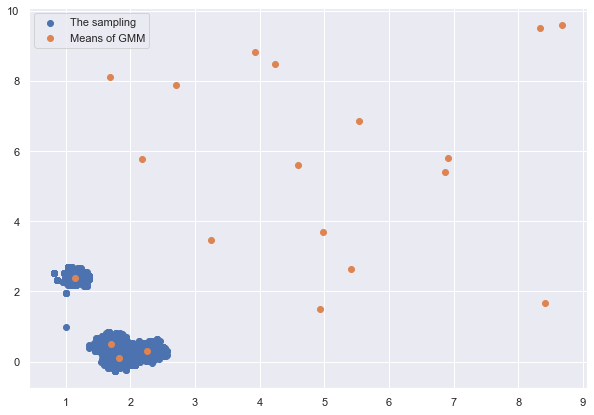

In [21]:
# Variables 
n = 20
d = 2
sigma = np.ones(n)*0.1
w = np.ones(n)*0.05
x = np.ones(d)
mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],
               [4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],
               [8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31], [5.54,6.86],[1.69,8.11]])


# Test the algorithm 
sam = sample(x, mu, sigma, w, n, d, N=10000)
      
    
# Plots 
plt.figure(figsize=(10,7))
plt.scatter(sam[:,0],sam[:,1] , label = 'The sampling')
plt.scatter(mu[:,0],mu[:,1], label = 'Means of GMM')
plt.legend()
plt.show()

**3. Autocorrelation Plots** 

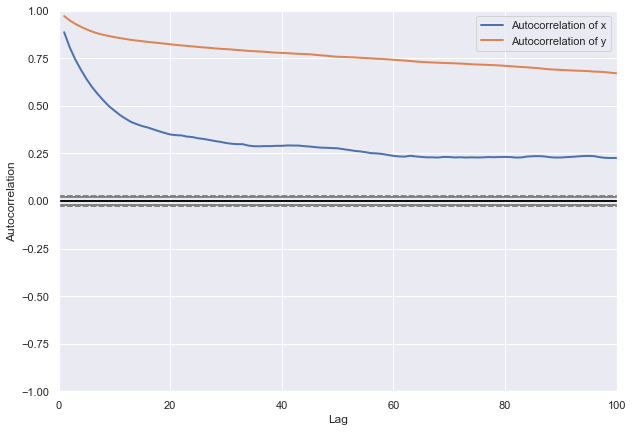

In [22]:
# Creating Autocorrelation plots
plt.figure(figsize=(10,7))
pd.plotting.autocorrelation_plot(sam[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(sam[:,1], label = 'Autocorrelation of y',linewidth=2)

# Limits the lags in the plot
plt.xlim((0,100))
plt.show()

**4. Interpretation** 

> The algorithm performs poorly on this example of target distribution. Indeed, the algorithm gets stuck in the local modes of the target distribution which are close to the initial point. Moreover, we clearly notice that the autocorrelation curves are very high and that they do not converge. 

#### <font color = 'red'> Question 2: 

Show that the Metropolis-Hastings algorithm (even the adaptive Metropolis-Hastings algorithm)
fails to sample from $\pi$. 

**1. Adaptive Metropolis-Hastings Symmetric Random Walk algorithm**

In [23]:
def Ada_sample(x, mu, sigma, w, n,d,N):

    # Initiate the variables 
    ## Old variables 
    sam = np.zeros((N,d))
    sam[0,:] = x
    acc_rate_x = 0
    acc_rate_y = 0
    ## New variables 
    l1 = 0
    l2 = 0
    j = 0
    
    for i in range(1,N):
        
        ####################
        # Sample from x axis
        ####################
        x_ = np.random.normal(sam[i-1,0],np.exp(l1))
        X = np.array([x_ , sam[i-1,1]])
        
        alpha_x = min(1 , pi(X,mu,sigma,w,n) / pi(sam[i-1,:],mu,sigma,w,n))
        u = np.random.rand()
        
        if u <= alpha_x: 
            sam[i,0] = x_
            acc_rate_x +=1
        else: 
            sam[i,0] = sam[i-1,0]          
    
        ####################
        # Sample from y axis
        ####################
        y_ = np.random.normal(sam[i-1,1],np.exp(l2))
        Y = np.array([sam[i,0] , y_])
        Y1 = np.array([sam[i,0] , sam[i-1,1]])
        
        alpha_y = min(1 , pi(Y,mu,sigma,w,n) / pi(Y1,mu,sigma,w,n))
        
        if u <= alpha_y: 
            sam[i,1] = y_
            acc_rate_y +=1
        else: 
            sam[i,1] = sam[i-1,1]  
            
        ####################
        # The adaptive part 
        ####################
        if (i % 50 == 0) : 
            j+=1
            if acc_rate_x/50 > 0.24 :
                l1 += min(0.01,1/np.sqrt(j))      
            else: 
                l1 -= min(0.01,1/np.sqrt(j))
                
            if acc_rate_y/50 > 0.24 :
                l2 += min(0.01,1/np.sqrt(j))      
            else: 
                l2 -= min(0.01,1/np.sqrt(j))
                
            acc_rate_x = 0 
            acc_rate_y = 0 
                
    return sam 

**2. Sampling Results** 

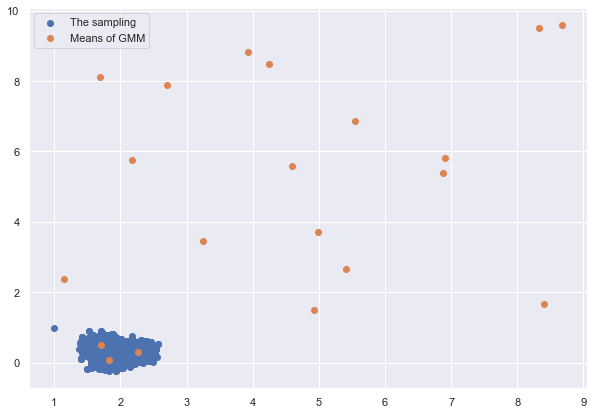

In [24]:
# Test the algorithm 
sam = Ada_sample(x, mu, sigma, w, n,d,10000)

# Plots 
plt.figure(figsize=(10,7))
plt.scatter(sam[:,0],sam[:,1] , label = 'The sampling')
plt.scatter(mu[:,0],mu[:,1], label = 'Means of GMM')
plt.legend()
plt.show()

**3. Autocorrelation Plots** 

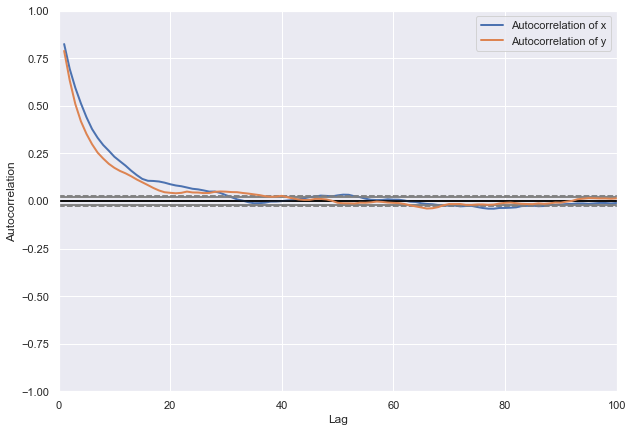

In [25]:
# Creating Autocorrelation plots
plt.figure(figsize=(10,7))
pd.plotting.autocorrelation_plot(sam[:,0], label='Autocorrelation of x',linewidth=2)
pd.plotting.autocorrelation_plot(sam[:,1], label = 'Autocorrelation of y',linewidth=2)

# Limits the lags in the plot
plt.xlim((0,100))
plt.show()

**4. Interpretation** 

> Even if we used the adaptive method, we remain stuck in the local modes. Here, the algorithm is not able to obtain samples of the other modes because they are well separated. However, we can see that the autocorrelation curves are becoming convergent.
<br> <br>
> $ \Longrightarrow $ From all these results, we can say that the Metropolis-Hastings algorithm (even the adaptive Metropolis-Hastings algorithm) fails to sample from the target distribution $ \pi $. 

### 2.B – Parallel Tempering

#### <font color = 'red'> Question 1: 

Implement the Parallel Tempering algorithm.

In [26]:
def parallel_tempering(T , N , d , mu , sigma , w , n_): 
    
    sam = np.zeros((len(T),N+1,d))
    
    for n in range(N):
        
        ####################
        # Draw Y for all i in [1,K]
        ####################s
        for i in range(len(T)): 
            
            t = T[i]
            
            ####################
            # Sample from x axis
            ####################
            x_ = np.random.normal(sam[i,n,0],0.25*np.sqrt(t))
            X = np.array([x_ , sam[i,n,1]])
            
            log_alpha_x = min(0 , np.log(pi(X,mu,sigma,w,n_))/t - np.log(pi(sam[i,n,:],mu,sigma,w,n_))/t)
            log_u = np.log(np.random.rand())
            
            if log_u <= log_alpha_x: 
                sam [i,n+1,0] = x_
            else: 
                sam [i,n+1,0] = sam [i,n,0] 
            
            ####################
            # Sample from y axis
            ####################
            y_ = np.random.normal(sam[i,n,1],0.25*np.sqrt(t))
            Y = np.array([sam[i,n+1,0] , y_])
            Y1 = np.array([sam[i,n+1,0] , sam[i,n,1]])

            log_alpha_y = min(0 , np.log(pi(Y,mu,sigma,w,n_))/ t - np.log(pi(Y1,mu,sigma,w,n_))/t)
            log_u = np.log(np.random.rand())

            if log_u <= log_alpha_y: 
                sam [i,n+1,1] = y_
            else: 
                sam [i,n+1,1] = sam [i,n,1] 
        
        ####################
        # Choose i and j 
        ####################
        i = np.random.randint(0,len(T)) 
        j = np.random.choice([i-1 , i+1]) 
        if i == 0 : j = i+1
        if i == len(T)-1 : j = i-1
            
        ####################
        ## Compute the swap acceptance probability
        ####################
        alpha_i = (pi(sam[j,n+1,:],mu,sigma,w,n_)**(1/T[i])) * (pi(sam[i,n+1,:],mu,sigma,w,n_)**(1/T[j]))
        alpha_j = (pi(sam[i,n+1,:],mu,sigma,w,n_)**(1/T[i])) * (pi(sam[j,n+1,:],mu,sigma,w,n_)**(1/T[j]))
        alpha = min(1, alpha_i / alpha_j)
    
        ####################
        ## Draw uniform variable 
        ####################
        u = np.random.rand()<alpha
        if u <= alpha : 
            aux = sam[i,n+1,:]
            sam[i,n+1,:] = sam[j,n+1,:]
            sam[j,n+1,:] = aux 

    return sam 

#### <font color = 'red'> Question 2: 

In order to illustrate the performance of the algorithm, use your code to sample from the distribution $\pi$ of Part A. Use the algorithm with $K = 5$ and with the following temperatures ladder: $(T1, . . . , T5) = ( 60, 21.6, 7.7, 2.8, 1 )$.
<br><br>
For the Metropolis-Hastings step (line 3), take as proposal distribution the bivariate Gaussian distribution centered at $X_n^{(i)}$, with variance-covariance matrix $\tau_i^2 I_2$: 

$$\forall i \in [1,K] ~~ Y_{n+1}^{(i)} \sim  \mathcal{N}_{\mathbb{R}^2} (X_n^{(i)}, \tau_i^2 I_2 ) ~~ \text{Where : } ~~ \tau_i = 0.25 \sqrt{T_i} $$ 

The scale parameters $\tau_i$ are tuned to ensure a reasonable acceptance rate in the algorithm.
<br><br>
In practice, the performance of the Parallel Tempering algorithm strongly depends on the choice of the temperatures ladder, the number of chains and the choice of proposal kernels. For most distributions, tuning these parameters may be infeasible. In [MMV13], the authors have proposed an adaptive Parallel Tempering algorithm to address these difficulties.

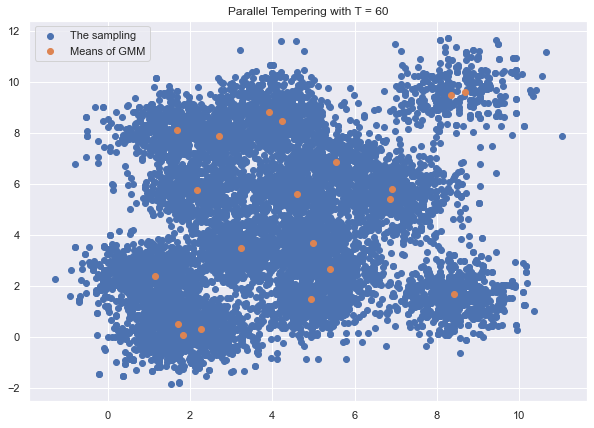

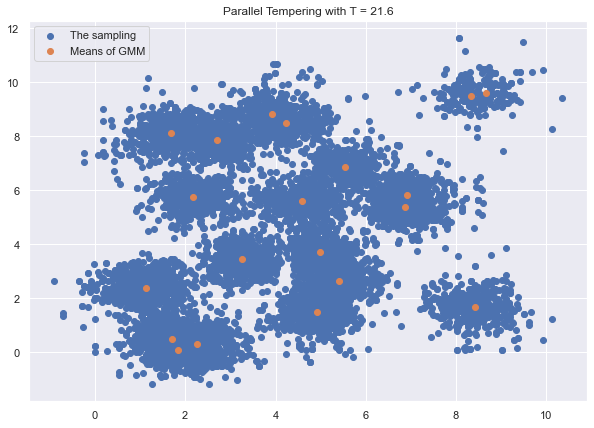

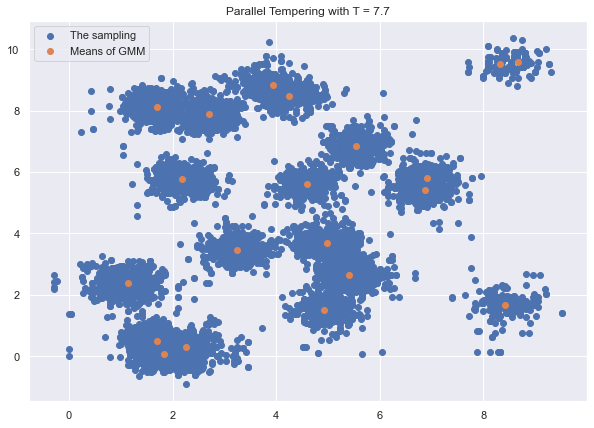

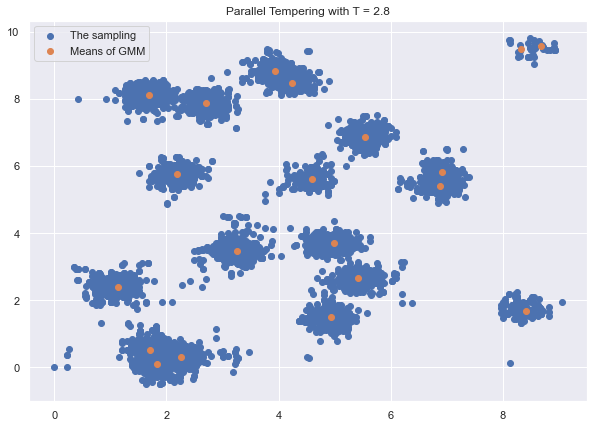

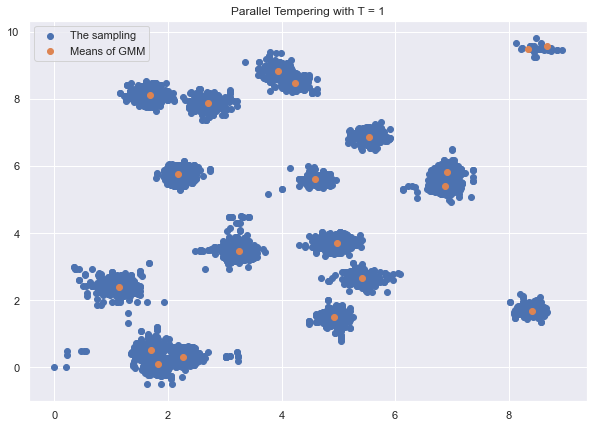

In [27]:
# Variables 
T = [60,21.6,7.7,2.8,1]
n = 20
d = 2
sigma = np.ones(n)*0.1
w = np.ones(n)*0.05
mu = np.array([[2.18,5.76],[8.67,9.59],[4.24,8.48],[8.41,1.68],[3.93,8.82],[3.25,3.47],[1.70,0.50],
               [4.59,5.60],[6.91,5.81],[6.87,5.40],[5.41,2.65],[2.70,7.88],[4.98,3.70],[1.14,2.39],
               [8.33,9.50],[4.93,1.50],[1.83,0.09],[2.26,0.31], [5.54,6.86],[1.69,8.11]])


# Test the algorithm 
sam = parallel_tempering (T , 10000 , d , mu , sigma , w , n)


# Plot for each T
for i in range(5): 
    plt.figure(figsize=(10,7))
    plt.scatter(sam[i,:,0],sam[i,:,1] , label = 'The sampling')
    plt.scatter(mu[:,0],mu[:,1], label = 'Means of GMM')
    plt.legend()
    plt.title('Parallel Tempering with T = ' + str(T[i]))
    plt.show()

**Interpretation** 

> From the previous results, using this temperature ladder, the number of chains and this choice of proposal kernels, we found that the sampling performance is very good. The parallel tempering algorithm is able to sample all modes, even if they are widely separated. Moreover, as the temperature decreases, the sampling becomes more accurate. 

## Exercise 3: Bayesian analysis of a one-way random effects model

#### <font color = 'red'> Question 1: 

Write the density of the a posteriori distribution $(X, \mu ,\sigma^2, \tau^2)$ — it can be given up to a normalizing constant — i.e the density of the distribution $(Y, X, \mu , \sigma^2, \tau^2)$.

**The poseterior distribution:**

$$\begin{aligned} P(X,\mu, \sigma^2,\tau^2 |Y) & \propto   P(Y , X , \mu, \sigma^2,\tau^2 ) \\
& \propto P(Y | X , \mu, \sigma^2,\tau^2 ) \times P(X|\mu, \sigma^2,\tau^2 ) \times P(\mu, \sigma^2,\tau^2 ) 
\end{aligned}$$ <br>
- $ P(Y | X , \mu, \sigma^2,\tau^2 )\propto (\frac{1}{\tau^2})^{\frac{Nk}{2}} exp(- \frac{\sum_i^N \sum_j^{k_i} (y_{i,j} - X_i)^2}{2 \tau^2}) 
$
-$ P(X|\mu, \sigma^2,\tau^2 ) \propto  (\frac{1}{\sigma^2})^{\frac{N}{2}} exp(- \frac{\sum_i^N (X_i - \mu)^2}{2 \sigma^2})  $  
- $ P(\mu, \sigma^2,\tau^2 )  \propto  \frac{1}{\sigma^{2(1+\alpha)}} exp(- \frac{\beta}{\sigma^2})  \frac{1}{\tau^{2(1+\gamma)}} exp(- \frac{\beta}{\tau^2}) $


$$\begin{aligned} P(X,\mu, \sigma^2,\tau^2 |Y) & \propto (\frac{1}{\tau^2})^{\frac{Nk}{2}} exp(- \frac{\sum_i^N \sum_j^{k_i} (y_{i,j} - X_i)^2}{2 \tau^2}) \times (\frac{1}{\sigma^2})^{\frac{N}{2}} exp(- \frac{\sum_i^N (X_i - \mu)^2}{2 \sigma^2}) \times \frac{1}{\sigma^{2(1+\alpha)}} exp(- \frac{\beta}{\sigma^2})  \frac{1}{\tau^{2(1+\gamma)}} exp(- \frac{\beta}{\tau^2}) \\\\
& \boxed{P(X,\mu, \sigma^2,\tau^2 |Y) \propto (\frac{1}{\tau^2})^{\frac{Nk}{2} + \gamma + 1 }  (\frac{1}{\sigma^2})^{\frac{N}{2} + \alpha + 1 }  exp(- \frac{\sum_i^N \sum_j^{k_i} (y_{i,j} - X_i)^2}{2 \tau^2} - \frac{\sum_i^N (X_i - \mu)^2}{2 \sigma^2} - \frac{\beta}{\sigma^2} -\frac{\beta}{\tau^2} ) }
\end{aligned}$$

#### <font color = 'red'> Question 2: 

Implement a Gibbs sampler which updates in turn $(\sigma^2,\tau^2,\mu, X)$ one at a time.

**Let's start first by computing:** 



> $P(\sigma^2|Y,X,\mu,\tau^2) \propto (\frac{1}{\sigma ^2})^{\frac{N}{2}+\alpha+1} exp(-\frac{\sum_{i}^N (X_i-\mu)^2}{2\sigma^2} -\frac{\beta}{\sigma^2}) $
<br><br>
>which is proportional to an Inverse Gamma Distribution of parameters $(\frac{N}{2}+\alpha,\frac{\sum_{i}^N (X_i-\mu)^2}{2} +\beta)$


> $P(\tau^2|Y,X,\mu,\sigma^2) \propto (\frac{1}{\tau^2})^{\frac{Nk}{2}+\gamma+1}exp(-\frac{\sum_{i}^N \sum_{j}^{k_i} (y_{i,j}-X_i)^2}{2\tau^2}-\frac{\beta}{\tau ^2})  $
<br><br>
> which is proportional to an Inverse Gamma Distribution of parameters $(\frac{Nk} {2}+\gamma,\frac{\sum_{i}^N \sum_{j}^{k_i} (y_{i,j}-X_i)^2}{2}+\beta)$
 
 
> $ \begin {aligned} P(\mu|Y,X,\sigma^2,\tau^2) & \propto exp(-\frac{\sum_{i}^N (X_i-\mu)^2}{2\sigma^2}) \\
& \propto exp(-\frac{\sum_{i}^N (X_i^2 -2\mu X_i + \mu^2)}{2\sigma^2}) \\
& \propto exp(-\frac{\frac{\sum_{i}^N X_i^2}{N} -2\mu \frac{\sum_{i}^N X_i}{N} +\mu^2)}{\frac{2\sigma^2}{N}})\\
& \propto exp(-\frac{(\frac{\sum_{i}^N X_i}{N})^2 -2\mu \frac{\sum_{i}^N X_i}{N} +\mu^2)}{\frac{2\sigma^2}{N}})\\
& \propto exp(-\frac{(\frac{\sum_{i}^N X_i}{N} - \mu)^2}{2\frac{\sigma^2}{N}})\\
\end{aligned}$
<br><br>
> which is proportional to the density of a gaussian distribution with parameters $(\frac{\sum_{i}^N X_i}{N}, \frac{\sigma^2}{N})$


> $ \begin{aligned}  P(X|Y,\mu,\sigma^2,\tau^2) & \propto exp(-\frac{\sum_{i}^N (X_i-\mu)^2}{2\sigma^2}) exp(-\frac{\sum_{i}^N \sum_{j}^{k_i} (y_{i,j}-X_i)^2}{2\tau^2}) \\ 
& \propto \prod_i^N exp(-\frac{(X_i-\mu)^2}{2\sigma^2}-\frac{\sum_{j}^{k_i} (y_{i,j}-X_i)^2}{2\tau^2}) \\
& \propto \prod_i^N exp(-\frac{X_i^2 -2\mu X_i + \mu^2}{2\sigma^2}-\frac{\sum_{j}^{k_i} (y_{i,j}^2 -2 y_{i,j} X_i + X_i^2)}{2\tau^2}) \\
& \propto \prod_i^N exp(- X_i^2(\frac{1}{2\sigma^2} + \frac{k_i}{2\tau^2}) + X_i (\frac{2\mu}{2\sigma^2} + \frac{2 \sum_j^{k_i} y_{i,j}}{2\tau^2}) - (\frac{\mu^2}{2 \sigma^2} + \frac{\sum_j^{k_i} y_{i,j}^2}{2\tau^2} )) \\ 
& \propto \prod_i^N exp(- \frac{((\frac{\tau^2 \mu + \sigma^2 \sum_j^{k_i} y_{i,j}}{\tau^2 + k_i \sigma^2})- X_i)^2}{2 \frac{\sigma^2 \tau^2}{\tau^2 + k_i \sigma^2}} )  
\end{aligned}
$
<br><br>
> We know that all $X_i $ are independent, then, each dentity distribution of $X_i$ is proportional to the density of a gaussian distribution with parameters $(\frac{\tau^2 \mu + \sigma^2 \sum_{j}^{k} y_{i,j} }{k \sigma^2 + \tau^2}, \frac{\sigma^2 \tau^2}{k \sigma^2 +\tau^2})$





In [28]:
def Gibbs_sampler(Y , sigma0, tau0 , mu0 , X0 , beta , alpha , gamma , N, k , num_samples) : 
    
    # Initiate Variables 
    sigma = []
    sigma_ = sigma0
    tau = []
    tau_ = tau0
    mu = []
    mu_ = mu0 
    X = []
    X_ = X0
    
    for i in range(num_samples):
        
        # Sample from distributions
        sigma_new = 1 / np.random.gamma(shape= N/2 + alpha , scale=1/(beta + np.sum((X_- mu_)**2)/2))
        tau_new = 1 / np.random.gamma(shape= N*k/2 + gamma , scale=1/(beta + np.sum((Y.T - X_)**2)/2))
        mu_new = np.random.normal(loc = np.mean(X_), scale=np.sqrt(sigma_/N))
        
        X_new = np.zeros(N)
        for j in range(N): 
            l = (tau_ * mu_ + sigma_*np.sum(Y[j,:]))/(k * sigma_ + tau_)
            s = np.sqrt((sigma_*tau_)/(k * sigma_ + tau_))
            X_new[j] = np.random.normal(loc = l ,scale= s) 
        
        sigma.append(sigma_new)
        tau.append(tau_new)
        mu.append(mu_new)
        X.append(X_new)
        
        sigma_ = sigma_new
        tau_ = tau_new
        mu_ = mu_new
        X_ = X_new
    
    return sigma, tau , mu, X

#### <font color = 'red'> Question 3: 

Implement a Block-Gibbs sampler which updates $\sigma^2$, then $\tau^2$ and then the block $(X, \mu)$.

**Let's start first by computing:** 


> $ \begin{aligned} P(X,\mu|Y,\sigma^2,\tau^2) & \propto \prod_{i=1}^N  exp(-\frac{\sum_{j}^{k_i} (y_{i,j}-X_i)^2}{2\tau^2} -\frac{(X_i-\mu)^2}{2\sigma^2}) \\
& \propto \prod_{i=1}^N  exp( -\frac{\sum_{j}^{k_i} (y_{i,j}^2 -2 y_{i,j} X_i + X_i^2)}{2\tau^2} -\frac{(X_i^2 -2\mu X_i + \mu^2)}{2\sigma^2}) \\
& \propto \prod_{i=1}^N exp(-\frac{1}{2}(\frac{(\sigma^2 k_i + \tau^2)X_i^2}{\tau^2 \sigma^2} -\frac{2 \sum_{j=1}^{k_i} y_{i,j} Xi}{\tau^2}-\frac{2X_i\mu}{\sigma^2}+\frac{\mu^2}{\sigma^2}))
\end{aligned} $ 
<br><br> 
> which is proportional to the density of a multivariate gaussian distribution with:
<br><br> 
> let's take $Z = (X,\mu) $, then: 
<br><br>
> $ cov(Z,Z) = \begin{pmatrix}
\frac{\sigma^2 k + \tau^2}{\tau^2 \sigma^2} & 0  & 0 & \frac{-1}{\sigma^2} \\
0 & \ddots &  0 & \vdots \\
0 & 0  & \frac{\sigma^2 k + \tau^2}{\tau^2 \sigma^2} & \frac{-1}{\sigma^2} \\
\frac{-1}{\sigma^2}  & \cdots  &  \frac{-1}{\sigma^2}  &  \frac{N}{\sigma^2} \\
\end{pmatrix}^{~~~-1} ~~ ; ~~ \mu(Z) = cov \times \begin{pmatrix}
\frac{\sum_{j=1}^{k} y_{i,j}}{\tau^2} & \cdots & \frac{\sum_{j=1}^{k} y_{i,j}}{\tau^2} \\
\end{pmatrix}$  

In [36]:
def Block_Gibbs_sampler(Y , sigma0, tau0 , mu0 , X0 , beta , alpha , gamma , N, k , num_samples):
    
    # Initiate Variables 
    sigma = []
    sigma_ = sigma0
    tau = []
    tau_ = tau0
    mu = []
    mu_ = mu0 
    X = []
    X_ = X0

    precision = np.zeros((N+1,N+1))
    Y_ = np.zeros(N+1)
    Y_[:N] = np.sum(Y, axis = 1).reshape(N)
    
    for i in range(num_samples): 
        
        # Sample from distributions
        sigma_new = 1 / np.random.gamma(shape= N/2 + alpha , scale=1/(beta + np.sum((X_- mu_)**2)/2))
        tau_new = 1 / np.random.gamma(shape= N*k/2 + gamma , scale=1/(beta + np.sum((Y.T - X_)**2)/2))

        for j in range(N) : 
            precision[j,j] = (k*sigma_ + tau_)/(sigma_* tau_)
        precision[:,N] = -1 / sigma_
        precision[N,:] = -1 / sigma_
        precision[N,N] = N / sigma_
        
        cov = np.linalg.pinv(precision)
        mean = np.dot(cov , Y_ / tau_)
        
        mvg = np.random.multivariate_normal(mean=mean,cov=cov,size=1).reshape(N+1)
        X_new=mvg[:N]
        mu_new=mvg[N]
        
        sigma.append(sigma_new)
        tau.append(tau_new)
        mu.append(mu_new)
        X.append(X_new)

        sigma_ = sigma_new
        tau_ = tau_new
        mu_ = mu_new
        X_ = X_new

    return sigma, tau , mu, X

#### <font color = 'red'> Question 4: 

Discuss the theoretical performance of these two algorithms.

> The Gibbs sampler is a method that is very easily implemented but may have severe problems. If the problem at hand is large and contains many loops, mixing may be too slow. Block Gibbs sampling usually avoids these problems by sampling the majority of variables jointly.
<br><br>
> Block Gibbs sampling is a method that combines exact local computations and Gibbs sampling, such that, instead of sampling a single variable at a time (“single-site Gibbs sampling”), a proportion of variables are sampled jointly by exact local computations. 
<br><br>
> This method performs better than does Gibbs sampling. In general, block Gibbs sampling mixes fast, whereas single-site Gibbs sampling often mixes very slowly or even gets completely stuck. 
<br><br>
> Moreover, block Gibbs sampling allows general inference in very large complex Bayesian networks as well as for many other problems requiring inference in large Bayesian networks. 
<br><br>
> Reference: https://www.sciencedirect.com/science/article/pii/S0002929707623398

#### <font color = 'red'> Question 5: 

Test your code on a synthetic dataset $Y = \{ y_{i,j} , i \in ]1,N[, j \in ]1, k_i[ \}$ generated from the previous model.

**1. Parameters**

In [30]:
N = 500
k = 100

# Target values
mu = 5
sigma = 1
tau = 0.5

# Initial parameters
sigma0 = 2
tau0 = 0.5
mu0 = 0.5

alpha=0.1
beta=0.1
gamma=0.1
num_samples = 10000

**2. Generate syntetic data**

In [31]:
Y = np.zeros((N,k))
for i in range(N):
    Xi = np.random.normal(loc=mu,scale=np.sqrt(sigma))
    epsiloni = np.random.normal(loc=0,scale=np.sqrt(tau),size=k)
    Y[i,:] = Xi + epsiloni

**3. Test the Gibbs sampler** 

In [32]:
X0 = np.zeros(N)
sigma, tau , mu, X = Gibbs_sampler(Y , sigma0, tau0 , mu0 , X0 , beta , alpha , gamma , N, k , num_samples) 

print('sigma :', np.mean(sigma))
print('mu :', np.mean(mu))
print('tau :',np.mean(tau))

sigma : 1.0853747590336733
mu : 4.933600672859496
tau : 0.5093577938841409


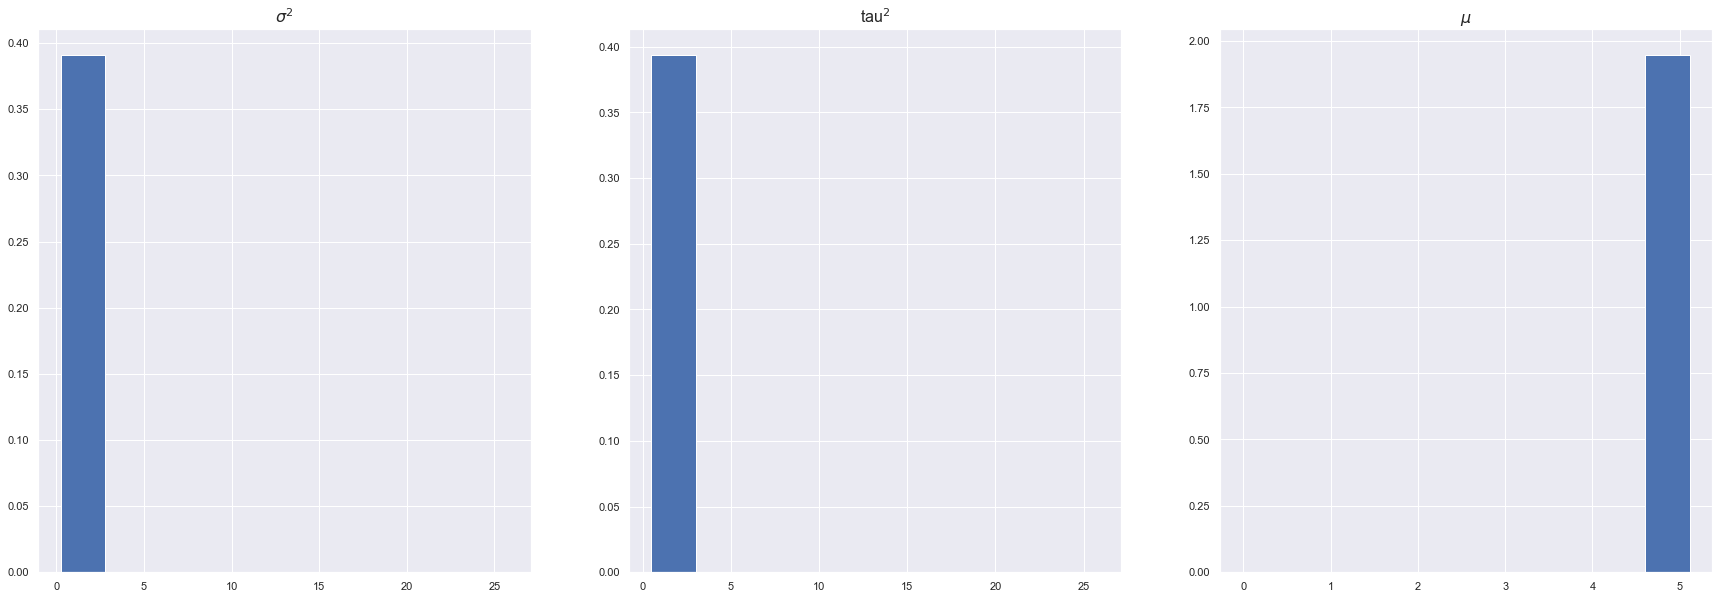

In [33]:
_,ax= plt.subplots(1,3,figsize=(30,10))

ax[0].hist(sigma,density=True)
ax[0].set_title('$\sigma^2$', fontsize =16)
ax[1].hist(np.array(tau),density=True)
ax[1].set_title('tau$^2$', fontsize =16)
ax[2].hist(mu,density=True)
ax[2].set_title('$\mu$', fontsize =16)
plt.show()

**4. Test the Block-Gibbs sampler**

In [34]:
sigma_ , tau_ , mu_ , X_ = Block_Gibbs_sampler(Y , sigma0, tau0 , mu0 , X0 , beta , alpha , gamma , N, k , num_samples)

print('sigma :', np.mean(sigma_))
print('mu :', np.mean(mu_))
print('tau :',np.mean(tau_))

sigma : 1.0826391597001686
mu : 4.935304769079783
tau : 0.5087068756161067


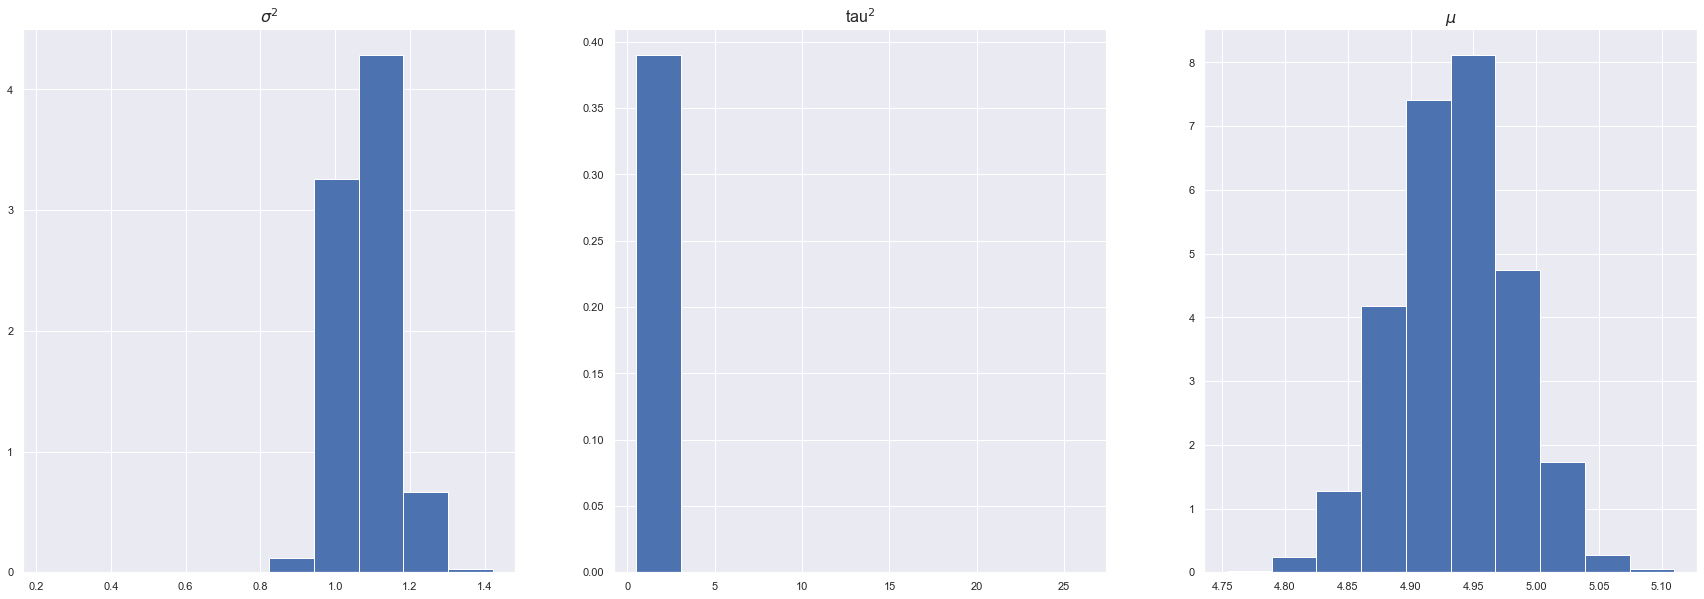

In [35]:
_,ax= plt.subplots(1,3,figsize=(30,10))

ax[0].hist(sigma_,density=True)
ax[0].set_title('$\sigma^2$', fontsize =16)
ax[1].hist(np.array(tau_),density=True)
ax[1].set_title('tau$^2$', fontsize =16)
ax[2].hist(mu_,density=True)
ax[2].set_title('$\mu$', fontsize =16)
plt.show()

**5. Interpretation** 

> From the previous results, we can confirm the theoretical results from the practical solutions. Indeed, the Block-Gibbs sampler has better performances than the Gibbs sampler. This is visible in the distribution of the sampled variables. But, in terms of average of the variables, both methods give values close to the target values. 